**Under construction**<br>

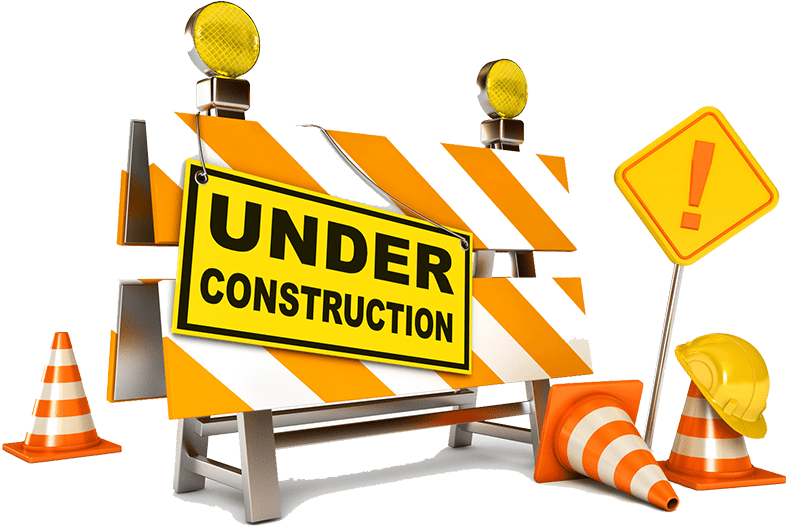

In [1]:
import IPython
IPython.display.Image("../assets/uc.png", width='30%')

Alexander S. Lundervold, October 7th, 2019

See also Geron's notebook: https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb

# Introduction

Random forests are **ensembles** of decision trees. As we've seen, a single decision tree is typically very sensitive to small changes in the training data and they tend to overfit. However, by constructing multiple decision trees in a particular way, and then combine them to make predictions, these problems are mitigated. As well as being less sensitive and less prone to overfitting, the resulting models, called **random forests**, have much higher performance. 

Ensembling techniques are related to the concept of the <a href="https://en.wikipedia.org/wiki/Wisdom_of_the_crowd">wisdom of the crowd</a>. In many situations, a crowd of non-expert that combine their predictions outperform individual experts. 

The idea is not new, of course. Here's Aristotle pointing this out back in 350 B.C.E:
> *For the many, of whom each individual is but an ordinary person, when they meet together may very likely be better than the few good, if regarded not individually but collectively, just as a feast to which many contribute is better than a dinner provided out of a single purse* <br>&ndash; Aristotle, <a href="http://classics.mit.edu/Aristotle/politics.3.three.html">Politics Book III</a>

# Setup

In [ ]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [ ]:
from pathlib import Path # Very convenient when working with paths in Python (https://docs.python.org/3.6/library/pathlib.html)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import seaborn as sns # For nicer plots

In [ ]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Ensembling

*Ensembling* is a general technique for combining machine learning models to make even more powerful models. 

There are several variants of this, as we'll see. **Voting**, **bagging**, **boosting**, **stacking**. We'll meet these concepts as we go along, but *we won't go into detail on ensembling in general, but rather focus on random forests and gradient boosting*. 

>**You should read through chapter 7 of the textbook to get a broader understanding of ensembling**.

Two very powerful and widely used models made using ensembling are **random forests**, based on bagging, and **gradient boosted decision trees**, based on boosting. We'll look at random forests here and gradient boosting in the next notebook. 

# Random forests

As we've seen, single decision trees tend to be very sensitive to the exact training data it's fed, and also tend to overfit. 

By training multiple decision trees on different parts of the training data, each one may overfit and be very sensitive, but by *averaging* their predictions, the sensitivity is reduced and the overfitting combatted. 

Let's say we want to build 500 trees on a training set containing `n_samples` point. Each tree is built in the following way:

1. Each tree trained on different data sets: Choose one data point at random for the training data, **with replacement**. Do this `n_samples` times, that is, until you have `n_samples` points. This is called **bootstrap sampling**.  
2. Each tree trained on different features: Train a decision tree on this data set, but at each node of the tree **select a random set of features to consider when splitting**, up to `max_features` of them.  

This is a random forest.

Predictions from a random forest is done differently for regression and classification: 

- **Regression:** Let each tree make a prediction, then average them.
- **Classification:** Let each tree make a prediction, and use a **soft voting strategy** to combine them. As we saw in the decision trees notebook, each tree provides a probability for its prediction. Average these probabilites and predict the class that has the highest average probability. 

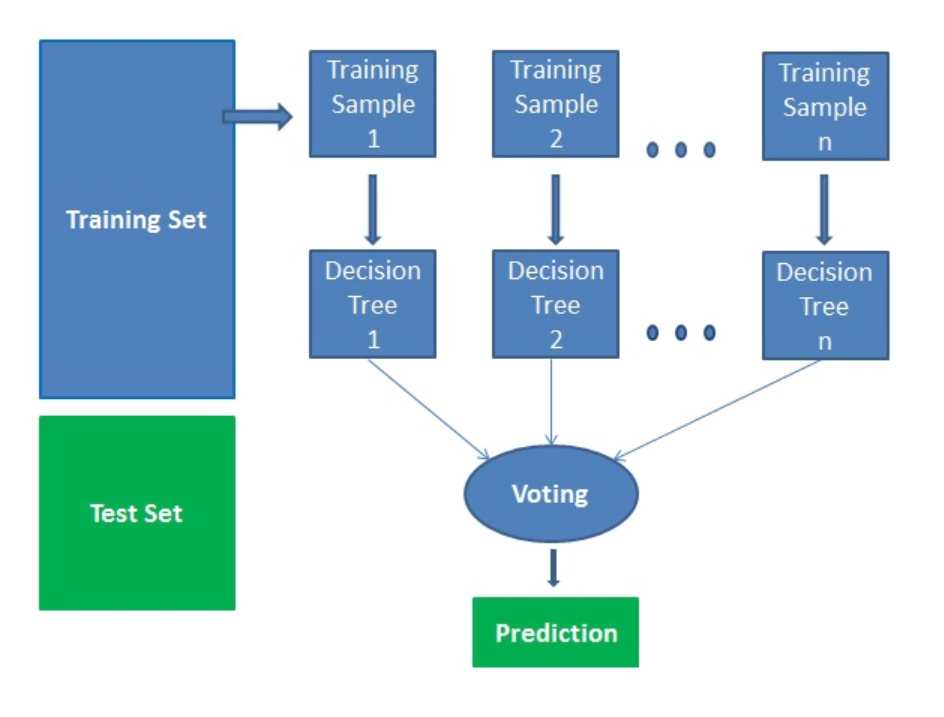

In [2]:
import IPython
IPython.display.Image("assets/rf_datacamp.PNG", width='70%')

<center><small>Picture from <a href="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg">here</a></center>

> **Your turn!** When you find the time it's highly recommended that you work through exercise 8 in Chapter 6 of the textbook. Here you'll essentially construct and train a random forest model yourself. You'll find some hints at the end of this notebook (don't look at them until you've tried to solve the exercise yourself). 

Let's try it out on a couple of (slightly complicated) data sets. 

> **Note:** We won't do much data preparation or feature engineering. We'll also not investigate the data sets very thoroughly. Feel free to add more details to the stories told below (following the steps in Assignment 1, for example). 

## Downloading data

Before getting to the random forest, let's have a quick look at typical ways for downloading data. 

When working with standard benchmark data sets it's typically best to download from one of the several large data repositories, e.g. [OpenML](https://openml.org), [Kaggle Datasets](https://www.kaggle.com/datasets), [UCI ML Repository](http://mlr.cs.umass.edu/ml/), or the [PMLB](https://github.com/EpistasisLab/penn-ml-benchmarks). These are widely used and there are great tools for browsing and downloading data through Python. 

Another common way to get data is downloading from an URL. The library `urllib` is super-handy for this.

In [ ]:
import urllib

In [ ]:
import urllib.request

Downloading from databases is of course also relevant. See https://www.dataquest.io/blog/python-pandas-databases/ for some pointers.

> You should always try to download the data directly from your Jupyter Notebook! It helps a lot with reproducibility, and makes it easier to understand your work (for yourself and others)

# Classification

## Download the data and have a quick look

We'll use a data set from OpenML:

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
dating = fetch_openml(name='SpeedDating')

> **Note:** This data set is also available from Kaggle https://www.kaggle.com/annavictoria/speed-dating-experiment. And in fact it's simpler to download it from there (using the Kaggle API). However, we want to be ready for a variety of possible data formats and sources that are out there. You should try to repeat what we do below by downloading the data from Kaggle using the Kaggle API.

This returns a `Bunch`:

In [ ]:
type(dating)

containing the entire data set including descriptions, accessible by keys:

In [ ]:
dating.keys()

Here's the description:

In [ ]:
print(dating['DESCR'])

The actual data is stored under the key `data`. It is a Numpy array with 8378 instances each with 120 features:

In [ ]:
dating['data'].shape

We prefer working with Pandas DataFrames, so let's create one:

In [ ]:
X = pd.DataFrame(data=dating['data'], columns=dating['feature_names'])
y = dating.target

In [ ]:
len(X), len(y)

In [ ]:
X.head()

In [ ]:
X.head(15).T.head(20) # The first 15 instances and the first 20 features

## Data exploration and preparation

### Dealing with missing values

There are many missing values in this data set, and we have to deal with them:

Total missing:

In [ ]:
X.isnull().sum().sum()

Missing by feature:

In [ ]:
pd.set_option("display.max_rows", None) # To print all rows below

In [ ]:
X.isnull().sum()

Sort according to number of missing:

In [ ]:
X.isnull().sum().sort_values(ascending=False)

Let's not think much about it and just drop the column `expected_num_interested_in_me` which has a *lot* of missing values, and put in the most common value elsewhere:

In [ ]:
X.drop('expected_num_interested_in_me', axis=1, inplace=True)

Impute the rest of the values (as you did in Assignment 1):

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
X_transformed = imputer.fit_transform(X)

We get an array

In [ ]:
X_transformed

...which we again turn into a data frame:

In [ ]:
X = pd.DataFrame(X_transformed, columns=X.columns)

In [ ]:
X.head()

No more missing values:

In [ ]:
X.isnull().sum().sum()

We notice that all the values seem to be integers, not floats. Let's guess that that's the case, and convert all the non-missing values to integers:

In [ ]:
X = X.astype('int32')

In [ ]:
X.head()

In [ ]:
X.info(verbose=1)

> We notice that many variables that are really categorical, even binary like `gender`. It's not necessary to store them as int32. It would be convenient to convert all categorical variables (there are 64 of them), and keep the numeric attributes (there are 59) as integers. Feel free to do this!

### Exploring the data

Let's explore the data a bit (but just a bit! Feel free to explore further on your own, perhaps by following the steps you took in Assignment 1).

We need to split off a test set before we start digging into the data:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Let's look at the age and gender distribution:

In [ ]:
X_train['age'].hist(figsize=(8,6))
plt.show()

In [ ]:
sns.countplot(X_train['gender'])
plt.show()

We notice that the speed dating event was quite balanced among the genders.

How successful were the participants? Let's count the number of people that found a match. This is stored in y:

In [ ]:
y[:5]

...as strings, it seems. It's more convenient to store it as integers: 

In [ ]:
y = [int(i) for i in y]

Percentage of matches:

In [ ]:
np.sum(y)/len(y) * 100

Only 16% of participants found a match after the speed dating experiment..

> Feel free to explore the data set further, perhaps by following your approach in Assignment 1 / Chapter 2. What can you say about correlations? Are there any features you should add? 

Let's move on to our random forest:

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)

In [ ]:
rf_clf.fit(X_train, y_train)

In [ ]:
rf_clf.score(X_test, y_test)

We can predict who will get a second date with more than 86% accuracy!

> And now for what everyone's waiting for: what are the most important features for getting a second date?

Let's first look at `feature_importances`. Then, remebering that feature importances are not very reliable, permutation importance like in previous notebooks.

**Feature importances**

In [ ]:
importances = rf_clf.feature_importances_

In [ ]:
indices = np.argsort(importances)[::-1]

Here are the top 10:

In [ ]:
for f in range(10): 
    print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

**Permutation importance**

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
perm = PermutationImportance(rf_clf, random_state=42).fit(X_test, y_test)

In [ ]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

How does the importance of the various features differ between men and women? To find out, we can train one model on men and another on women.

In [ ]:
X_train_men, y_train_men = X_train.loc[X_train['gender'] == 1], y_train[X_train['gender'] == 1]

X_train_women, y_train_women = X_train.loc[X_train['gender'] == 0], y_train[X_train['gender'] == 0]

In [ ]:
rf_clf_men = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_men.fit(X_train_men, y_train_men)

In [ ]:
rf_clf_women = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf_women.fit(X_train_women, y_train_women)

In [ ]:
def print_feature_importances(clf, num):
    """
    Prints the num most important features of the trained classifier clf
    """
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(num): 
        print(f'{X.columns[indices[f]]}: {np.round(importances[indices[f]],3)}')

In [ ]:
print_feature_importances(rf_clf_men, 10)

In [ ]:
print_feature_importances(rf_clf_women, 10)

Not how this differs from the permutation importance (which in general is more believable): 

In [ ]:
def print_permutation_importances(clf):
    """
    Prints the num most important features of the trained classifier clf
    """
    perm = PermutationImportance(clf, random_state=42).fit(X_test, y_test)
    display(eli5.show_weights(perm, feature_names = X_test.columns.tolist()))

In [ ]:
print_permutation_importances(rf_clf_men)

In [ ]:
print_permutation_importances(rf_clf_women)

> It could be interesting to look at partial dependence plots as well. Feel free to try it out!

Notice that we overfit the training data:

In [ ]:
rf_clf.score(X_train, y_train)

Looking at the parameters of the random forest above, and thinking back to decision trees, we can guess how we can regularize the model to reduce the overfitting. For example, we can reduce the minimum number of samples each leaf must contain, and/or the maximum number of leaf nodes:

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_leaf_nodes=20, random_state=42)

In [ ]:
rf_clf.fit(X_train, y_train)

In [ ]:
rf_clf.score(X_test, y_test)

In [ ]:
rf_clf.score(X_train, y_train)

## Wait a minute!

We are pretty happy with ourselves: we're able to predict matches with an accuracy of 85%, and we've found some fun results on gender differences in dating. 

<br>
<center><b><span style="font-size:300%">BUT!</span></b></center>

Only 16% of the participants are marked as matches. Therefore, if we predict everyone to be `match=0` we'll score about 84%... Making 85% not very impressive.. 

If only there were ways to evaluate classifiers more carefully than accuracy... :-) Luckily, we've studied classification very thoroughly in Part 2, and are equipped with many tools. 

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = rf_clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
import itertools

*Below code taken from Part 2*:

In [ ]:
def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

In [ ]:
_ = plot_confusion_matrix(cm, ['not match', 'match'])

We see that our model is **almost rubbish**! Invalidating all the fun observations we did above. Beware of such mistakes!

> **Your turn!** Use the above confusion matrix to calculate the **precision** and **recall** of the classifer by hand. See Part 2 of the course if you've forgotten how. Then do the same using scikit-learn.

> **Your turn!** Try to improve the model by finding better hyperparameters and perhaps also better imputing strategies. You can also consider adding new features, and removing some that seem unimportant. Remember to do your model selection based on a validation data set.

# Another classification example

Let's have a look at how machine learning can be used on electronic health records data through a (small) example. See the lecture slides for motivation. 

From data gathered from 100.000 patients, collected by Microsoft here https://microsoft.github.io/r-server-hospital-length-of-stay/index.html, we will try to predict the length of stay of patients admitted to the hospital. Such a system (if it was sufficiently robust and accurate) would be extremely valuable. For hospital resource management, i.e. managing personnel and planning for patient discharge at hospital departments. By investigating what features have the largest explanatory power for a trained machine learning model, such a system could also potentially uncover interesting connections between journal data and patient conditions. 

I've downloaded and prepared the data, stored in the data folder:

## Load and inspect the data

In [ ]:
DATA = Path('./part4data/hospital')

The data set consists of three files:

In [ ]:
LOS = pd.read_pickle(DATA/'hospital')
DICT = pd.read_excel(DATA/'Data_Dictionary.xlsx')
METADATA = pd.read_csv(DATA/'MetaData_Facilities.csv')

In [ ]:
LOS.head()

In [ ]:
LOS.info()

In [ ]:
DICT

In [ ]:
METADATA

### Observations

It seems that `LOS` is our main source of information. `DICT` provides useful information about the features in `LOS`, while `METADATA` contains information about the various hospital departments the data is collected from.

> **OBS**: I have changed the features in our version of `LOS` a bit compared to the [original](https://github.com/Microsoft/r-server-hospital-length-of-stay/raw/master/Data/LengthOfStay.csv). All stays longer than 8 days have been merged. All the `rcount` marked as "5+" have been set to 5.

## Further exploration

What is the length of stay distribution?

In [ ]:
LOS_value_count = LOS['lengthofstay'].value_counts()
LOS_value_count

In [ ]:
LOS_value_count.plot.barh(figsize=(12,8))
plt.show()

We note that the data set is pretty imbalanced. Most of the stays at the hospital are short.

How's the gender balance?

In [ ]:
gender_counts = LOS['gender'].value_counts()
gender_counts.plot.bar()
plt.show()

A bit more men than women.

Is there a difference in how long they stay at the hospital?

In [ ]:
# First we convert "more than 8" to the number 9, for plotting purposes:
LOS_tmp = LOS.copy()

In [ ]:
LOS_tmp['lengthofstay'].loc[LOS_tmp['lengthofstay'] == 'more than 8'] = 9 # Convert "more than 8" to 9

LOS_tmp['lengthofstay'] = LOS_tmp['lengthofstay'].astype(int) # Change to integers

# Box plot:
ax = sns.boxplot(x='gender', y='lengthofstay', data=LOS_tmp)

### Correlations

How do the numerical features correlate to length of stay?

In [ ]:
DICT

In [ ]:
correlation_matrix = LOS_tmp.corr()
correlation_matrix['lengthofstay'].sort_values(ascending=False)

**Observations:**

* `rcount` is very correlated to length of stay. The number of hospital visits during the last 180 days says a lot about expected length of stay.
* `facid` is also quite correlated. That could be caused by varying capacity of the different departments, and the different patient population they serve.

Most patients haven't been to the hospital during the last 180 days, but some are frequent guests:

In [ ]:
LOS['rcount'].value_counts().plot.bar()
plt.show()

Here's the capacity of the different departments:

In [ ]:
METADATA

In [ ]:
METADATA.plot(x='Id', y='Capacity', kind='bar')
plt.show()

## Let's try to make a predictive model

We treat this as a classification problem. I.e. 

> Is the expected length of stay 1, 2, 3, 4, 5, 6, 7, 8 or more than 8 days?

It's also possible to treat it like regression. Feel free to try!

In [ ]:
X = LOS.drop('lengthofstay', axis=1)
y = LOS['lengthofstay']

### Separate a test set

To simulate the real situation where our model is used to predict length of stay as a new patient arrives, we set aside a test set to evaluate the model.

In [ ]:
from sklearn.model_selection import train_test_split

As the data set is quite imbalanced we use a stratified split. This ensures that the length of stay distribution is the same in the training and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Select a model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

<span style="font-size:200%">MORE TO BE ADDED</span>